<a href="https://colab.research.google.com/github/ConSeanway/invSim/blob/master/Sean_Inventory_Simulation_27SEP2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventory Simulation
## Authors:  Sean Conway + Yanzhe Ma

---

Summer 2020 - Fall 2020 Semester
Last Modified: 22SEP2020

> Implementation of Inventory Simulation Using Classes



In [48]:
import numpy as np
import pandas as pd
import pprint
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections.abc import Iterable

def iterable(obj):
    return isinstance(obj, Iterable)

Inventory Simulation Class

In [4]:
df = pd.read_csv("3_node_60_60_60.csv")
print(df["IS 3 Node"][len(df["IS 3 Node"])-1])


44.49149011


In [5]:
# "Game" class that can be created to run the whole simulation
class InvSimulation:
  def __init__(self, periodsToSimulate=1000):
    self.periodsToSimulate = periodsToSimulate

    # Contains all of the nodes in our simulation (reference by ID)
    self.nodeDict = {}

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

# Node - related methods

  def createNode(self, nodeID, h, p, nodeType="retailer", demandMean=0, demandStDev=0):
    '''
    Creates a node to be used in our supply network
    In:  InvSim object, nodeID, h, p, nodeType, demandMean, demandStDev
    '''
    self.nodeDict[nodeID] = Node(nodeID, h, p, nodeType,demandMean, demandStDev)
  
  #links together two nodes in preDict and recDict; could add a boolean later for linking both ways
  def linkNode(self,startNode,endNode,relationshipType="or"):

    '''
    Create a unidirectional link between nodes
    In: InvSim object, starting Node index, ending Node index

    recDict[] maps one starting node to all of its receiving nodes
    preDict[] maps one ending node to all of its predecessor nodes
    '''
    
    if startNode in self.nodeDict[startNode].recDict.keys():
      self.nodeDict[startNode].recDict[startNode].append(endNode)
    else:
      self.nodeDict[startNode].recDict[startNode] = []
      self.nodeDict[startNode].recDict[startNode].append(endNode)
    
    if endNode in self.nodeDict[endNode].preDict.keys():
      self.nodeDict[endNode].preDict[endNode].append(startNode)
    else:
      self.nodeDict[endNode].preDict[endNode] = []
      self.nodeDict[endNode].preDict[endNode].append(startNode)
  
  #This method adds in all of the combinations of nodeID and the number of units needed to produce one unit for "thisNode"
  def addAndRelationship(self,upstreamNodeID,downstreamNodeID,numNeeded):
    thisNode = self.nodeDict[upstreamNodeID]
    if (upstreamNodeID,downstreamNodeID) not in thisNode.ANDDict.keys():
      thisNode.ANDDict[(upstreamNodeID,downstreamNodeID)] = []
    thisNode.ANDDict[(upstreamNodeID,downstreamNodeID)].append(numNeeded)
#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

  def playSimulation(self, gameType="multiNodeVerify", BSLevel=60, demandMethod="useFileDemand", fileDemand=df["IO"], seed='N/A', connectionCase="or", printOut=True):
    '''
    Play the simulation, given the following:
    - game type (string) (default="multiNodeVerify)
    - base stock level (integer for multiNodeVerify game), single value for all nodes (default=60)
    '''

    if gameType == "multiNodeVerify":
      if demandMethod == "useFileDemand":
        self.multiNodeVerify(demandArray=fileDemand, BSLevel=BSLevel, connectionCase=connectionCase, demandMethod=demandMethod, printOut=printOut)
      elif demandMethod == "useRandomDemand":
        self.multiNodeVerify(BSLevel=BSLevel, connectionCase=connectionCase, demandMethod=demandMethod, seed=seed, printOut=printOut)
    else:
      self.playOptimalBaseStockGame()

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
  def printEndStats(self, nodeID, thisNode, period):
      '''
      Print the resulting statistics for a node in the game
      In:
      - nodeID (integer)
      - thisNode (node Object)
      - period (integer)
      '''

      print("Node " + str(nodeID))
      print("(IL) Starting Inventory record for node " + str(nodeID) + ":" + str(thisNode.startingInventoryRecord))
      print("(IS) Inbound supply record for node " + str(nodeID) + ":" + str(thisNode.receivedMats))
      print("(IO) Demand for node " + str(nodeID) + ":" + str(thisNode.demandArray))
      print("(OQ) Order for node " + str(nodeID) + ":" + str(thisNode.orderArray))
      print("(DMFS) Supply for node " + str(nodeID) + ":" + str(thisNode.supplyArray))
      print("(EIL) Ending Inventory record for node " + str(nodeID) + ":" + str(thisNode.endingInventoryRecord))
      print("(BO) Backorders for node " + str(nodeID) + ":" + str(thisNode.backorderRecord))
      print("(TC) Total Cost for node " + str(nodeID) + ":" + str(thisNode.costRecord))
      print()

        #diffIS = []
        #if nodeID == 2:
        #  for i in range(0,min(len(thisNode.inBoundOrders),len(df["IS 3 Node"]))):
        #    diffIS.append(thisNode.inBoundOrders[i]-df["IS 3 Node"][i])
        #  print(diffIS)
        #  print(len(thisNode.inBoundOrders))

  def getReceivedMaterialsOrCase(self, nodeID, thisNode, period):
    '''
    Get the number of inbound materials from what the preceding node was able to supply

    Example:
    Flow of material
    o -> o

    Suppose the left node represents a wholesaler, and the right node represents a retailer
    How much material was the wholesaler able to supply to the retailer?

    In:
    - nodeID (dictionary key)
    - period (integer)

    Out:
    - number of received materials (numeric)
    '''

    # Get the number of inbound materials from what the previous node was able to supply
    receivedMatsNum = 0
    upstreamNum= 0
    upstreamList = []
    #For every node that's not the end supplier 
    if len(self.nodeDict[nodeID].recDict) != 0 and period != 0:
      #Step 1: get the number of upstream nodes
      upstreamList = self.nodeDict[nodeID].recDict[nodeID]
      for upstreamNode in upstreamList:
        #Step 2: For every upstream node, find out the total number of downstream nodes
        downstreamNum = len(self.nodeDict[upstreamNode].preDict[upstreamNode])
        #Step 3: For every upstream node, find out the total number of finished materials that could be delievered downstream
        totFinishedMatsNum = self.nodeDict[upstreamNode].supplyArray[period-1]
        #The number of finished goods that could be delivered to this particular node = total finished goods/total number of downstream nodes
        finishedMatsNum = totFinishedMatsNum/downstreamNum
        #Sum up all such finished goods received from upstream nodes to get the total number of received materials
        receivedMatsNum += finishedMatsNum

    # If a node has no receivers, we assume that it'll always be supplied the qty it wants
    elif len(self.nodeDict[nodeID].recDict) == 0 and period != 0:
      if iterable(self.nodeDict[nodeID].orderArray[period - 1]):
        receivedMatsNum = max(self.nodeDict[nodeID].orderArray[period - 1].sum(), 0)
      else:
        receivedMatsNum = max(self.nodeDict[nodeID].orderArray[period - 1], 0)
    thisNode.receivedMats.append(receivedMatsNum)
    return receivedMatsNum
  
  def getReceivedMaterialsANDCase(self, nodeID, thisNode, period):
    '''
    Get the number of inbound materials from what the preceding node was able to supply

    Example:
    Flow of material
    o -> o

    Suppose the left node represents a wholesaler, and the right node represents a retailer
    How much material was the wholesaler able to supply to the retailer?

    In:
    - nodeID (dictionary key)
    - period (integer)

    Out:
    - number of received materials (numeric)
    '''

    # Get the number of inbound materials from what the previous node was able to supply
    receivedMatsNum = 0
    upstreamNum= 0
    upstreamList = []
    finishedMatsList = []
    #For every node that's not the end supplier 
    if len(self.nodeDict[nodeID].recDict) != 0 and period != 0:
      #Step 1: get the number of upstream nodes
      upstreamList = self.nodeDict[nodeID].recDict[nodeID]
      for upstreamNode in upstreamList:
        #Step 2: For every upstream node, find out the total number of downstream nodes
        downstreamNum = len(self.nodeDict[upstreamNode].preDict[upstreamNode])
        #Step 3: For every upstream node, find out the total number of finished materials that could be delievered downstream
        totFinishedMatsNum = self.nodeDict[upstreamNode].supplyArray[period-1]
        #The number of finished goods that could be delivered to this particular node = total finished goods/total number of downstream nodes
        finishedMatsNum = totFinishedMatsNum/downstreamNum
        #Append finishedMatsNum from every node to the finishedMatsList
        finishedMatsList.append(finishedMatsNum)
      #AND Relationship: find out the minimum of all finishedMatsNum 
      receivedMatsNum = min(finishedMatsList)

    elif len(self.nodeDict[nodeID].recDict) == 0 and period != 0:
      if iterable(self.nodeDict[nodeID].orderArray[period - 1]):
        receivedMatsNum = max(self.nodeDict[nodeID].orderArray[period - 1].sum(), 0)
      else:
        receivedMatsNum = max(self.nodeDict[nodeID].orderArray[period - 1], 0)
    thisNode.receivedMats.append(receivedMatsNum)
    return receivedMatsNum

  def computeDemandOrCase(self, nodeID, thisNode, demandArray, demandMethod, period):
    '''
    Compute the demand for a given node (using a demand array as reference)
    In:
    - nodeID (dictionary Key)
    - thisNode (Node)
    - demandArray (array of numerics)
    - period (integer)
    '''
    downstreamNum = 0
    downstreamList = []
    downstreamNodeDemand = 0
    totDemand = 0
    demandUpstreamNum = 0
    
    # Pull demand from the demand array if it's the retailer
    # Upstream nodes look at what the previous node's order was (that is in turn their demand)
    ### THIS WILL ALSO NEED TO CHANGE TO BE GENERALIZABLE TO THE MULTI-RETAILER CASE
    # if nodeID == 0:
    if len(thisNode.preDict) == 0:
      if demandMethod == "useFileDemand":
        totDemand = demandArray[period]
      else:
        totDemand = np.random.normal(loc=thisNode.demandMean, scale=thisNode.demandStDev)
    else:
      #Step 1: get the number of downstream nodes this node has 
      downstreamList = thisNode.preDict[nodeID]
      downstreamNum = len(downstreamList)
      #Step 2: Calculate the number of units demanded for each downstream node
      for downstreamNode in downstreamList:
        #Step 3: find out the number of upstream nodes for the current downstream node
        demandUpstreamNum = len(self.nodeDict[downstreamNode].recDict[downstreamNode])
        #Find out this downstream node's total demand for this period (assuming no delay in placing orders to upstream nodes)
        downstreamNodeDemand = self.nodeDict[downstreamNode].orderArray[period]
        #This node's demand from the current downstream node = total demand/#upstream nodes for this downstream node
        thisNodeDemand = downstreamNodeDemand/demandUpstreamNum
        #Sum up all demands to get the total demand for this node
        totDemand += thisNodeDemand

    #print("Node " + str(thisNode.id))
    #print("Demand " + str(totDemand))
    #print()

    # Incur the demand by appending it to the node's demand array (this is basically just being pulled from the file)
    thisNode.demandArray.append(totDemand)
    return totDemand

  def computeDemandAndCase(self, nodeID, thisNode, demandArray, demandMethod, period):
    '''
    Compute the demand for a given node (using a demand array as reference)
    In:
    - nodeID (dictionary Key)
    - thisNode (Node)
    - demandArray (array of numerics)
    - period (integer)
    '''
    downstreamNum = 0
    downstreamList = []
    downstreamNodeDemand = 0
    totDemand = 0
    demandUpstreamNum = 0
    
    # Pull demand from the demand array if it's the retailer
    # Upstream nodes look at what the previous node's order was (that is in turn their demand)
    # THIS IS CHANGED
    # if nodeID == 0
    if len(thisNode.preDict) == 0:
      if demandMethod == "useFileDemand":
        totDemand = demandArray[period]
      else:
        totDemand = np.random.normal(loc=thisNode.demandMean, scale=thisNode.demandStDev)
    else:
      #Step 1: get the number of downstream nodes this node has 
      downstreamList = thisNode.preDict[nodeID]
      downstreamNum = len(downstreamList)
      #Step 2: Calculate the number of units demanded for each downstream node
      for downstreamNode in downstreamList:       
        #Find out this downstream node's total demand for this period (assuming no delay in placing orders to upstream nodes)
        downstreamNodeDemand = self.nodeDict[downstreamNode].orderArray[period]    
        #Sum up all demands to get the total demand for this node
        totDemand += downstreamNodeDemand

    #print("Node " + str(thisNode.id))
    #print("Demand " + str(totDemand))
    #print()

    # Incur the demand by appending it to the node's demand array (this is basically just being pulled from the file)
    thisNode.demandArray.append(totDemand)
    return totDemand

  def satisfyDemand(self, receivedMats, thisNode, thisPeriodDemand, backordersFulfilled):

    '''
    Given the demand, as well as the supply for a node for a current period, compute
    how much of this node's demand can be supplied (and how many backorders result)

    Record this information in the node

    In:
    - Received materials (numeric)
    - node object (Node)
    - demand for this period (numeric)

    '''

    availableSupply = receivedMats + max(thisNode.startingInventory,0)

    # Record demand that can be supplied, along with the backorders that were fulfilled
    if iterable(thisPeriodDemand):
      totDemand = thisPeriodDemand.sum()
    totDemand = thisPeriodDemand
    suppliableDemand = min(availableSupply, totDemand)
    thisNode.supplyArray.append(suppliableDemand + backordersFulfilled)
    thisNode.backordersFulfilledArray.append(backordersFulfilled)

  def computeEIAndCosts(self, thisNode, thisPeriodDemand, receivedMats, backordersFulfilled):
    if iterable(thisPeriodDemand):
      thisNode.endingInventory = thisNode.startingInventory - thisPeriodDemand.sum() + receivedMats + backordersFulfilled
    else:
      thisNode.endingInventory = thisNode.startingInventory - thisPeriodDemand + receivedMats + backordersFulfilled
    thisNode.backorders = -1 * min(0, thisNode.endingInventory)
    thisNode.backorderRecord.append(thisNode.backorders)
    thisPeriodCost = max(0,thisNode.endingInventory*thisNode.holdingCost)+max(0,-1*thisNode.endingInventory*thisNode.stockoutCost)
    thisNode.endingInventoryRecord.append(thisNode.endingInventory)
    thisNode.costRecord.append(thisPeriodCost)


  def getPdToSimulate(self, demandArray):
    availablePdToSimulate = 0
    if len(demandArray) == 0:
       availablePdToSimulate = self.periodsToSimulate + 1
    else:
      availablePdToSimulate = len(demandArray)
    return availablePdToSimulate

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

  def multiNodeVerify(self, demandArray=[], BSLevel=60, connectionCase="or", demandMethod="useRandomDemand", seed="N/A", printOut=True):

    '''
    Run instance of the game using a preset demand
    In:
    - demandArray:  array of numerics, containing demand for each node
    - BSLevel: (optional, default=60) Base stock level (numeric)
    '''

    # Apply an RN seed if we need one
    if seed != "N/A":
      np.random.seed(seed)

    if type(BSLevel) == dict:
      # Read the base stock level in from the dictionary
      for nodeID in sorted(self.nodeDict.keys()): self.nodeDict[nodeID].initGame(BSLevel[nodeID])
    else:
      # Reset lists from previous runs
      for nodeID in sorted(self.nodeDict.keys()): self.nodeDict[nodeID].initGame(BSLevel)

    availablePdToSimulate = self.getPdToSimulate(demandArray)
      
    # Determine order quantity for the current period for all nodes (prior to demand determination)
    for period in range(0, min(availablePdToSimulate, self.periodsToSimulate)):
      for nodeID in sorted(self.nodeDict.keys()):

        thisNode = self.nodeDict[nodeID]       

        # Record starting inventory, and get materials from upstream node
        thisNode.startingInventoryRecord.append(thisNode.startingInventory)
        if connectionCase == "and":
          receivedMats = self.getReceivedMaterialsANDCase(nodeID, thisNode, period)
        else:
          receivedMats = self.getReceivedMaterialsOrCase(nodeID, thisNode, period)        

        # Determine how many backorders can be fulfilled
        backordersFulfilled, receivedMats = thisNode.getBackorders(receivedMats)

        # Compute the demand, and satisfy as much of it as we are able (during this period)
        if connectionCase == "and":
          thisPeriodDemand = self.computeDemandAndCase(nodeID, thisNode, demandArray, demandMethod, period)
        else:
          thisPeriodDemand = self.computeDemandOrCase(nodeID, thisNode, demandArray, demandMethod, period)

        self.satisfyDemand(receivedMats, thisNode, thisPeriodDemand, backordersFulfilled)

        # Order the same quantity as the demand from this period
        qtyToOrder = thisPeriodDemand
        thisNode.orderArray.append(qtyToOrder)

        # Compute the ending inventory and costs for this period (and print resulting statistics)
        self.computeEIAndCosts(thisNode, thisPeriodDemand, receivedMats, backordersFulfilled)

        if printOut == True and (period == self.periodsToSimulate - 1):
          self.printEndStats(nodeID, thisNode, period)
        
        # Make the starting inventory equal to ending inventory from previous period
        thisNode.startingInventory = thisNode.endingInventory

In [83]:
class Node:

  def __init__(self, id, h=3, p=100, nodeType = "retailer",demandMean=50, demandStDev=10):

    '''
    Node represents a single node on our supply network
    In:
    - NodeID (required, we recommend using integers 0-inf)
    - h (unit holding cost) (numeric), default = 3
    - p (unit stockout cost) (numeric), default = 100
    - nodeType (description of node type) (string), default = "retailer"
    - demandMean (mean of the demand function) (numeric), default = 50
    - demandStDev (standard deviation of the demand function) (numeric), default = 10

    Note that we are currently assuming normal demands (perhaps specify other distributions if you want)
    '''

    self.id = id
    
    self.holdingCost = h
    self.stockoutCost = p
    self.baseStockLevel = 0

    self.startingInventory = self.baseStockLevel
    self.endingInventory = 0
    
    self.nodeType = nodeType
    self.backorders = 0

    # This is assuming that in this game, we have an idea of the distribution params for demand
    self.demandMean = demandMean
    self.demandStDev = demandStDev

    # Add 2 dictionaries, one for recording recipients and one for predecessors, to each node for cross-node implementations
    self.preDict = {}
    self.recDict = {}
    #Create a dictionary that stores the nodes that have "AND" relationships with the current node
    self.ANDDict = {}

    self.demandArray  = []
    self.orderArray = []
    self.supplyArray = []
    self.backordersFulfilledArray = []
    
    self.startingInventoryRecord = []
    self.endingInventoryRecord = []
    self.backorderRecord = []
    self.receivedMats = []
    self.costRecord = []

  def initGame(self, BSLevel):
    self.demandArray  = []
    self.orderArray = []
    self.supplyArray = []
    self.backordersFulfilledArray = []
    
    self.startingInventoryRecord = []
    self.endingInventoryRecord = []
    self.backorderRecord = []
    self.receivedMats = []
    self.costRecord = []
    # Initialize the base stock level for period 0 and beyond, also starting inventory for period 0
    self.startingInventory = BSLevel
    self.baseStockLevel = BSLevel
    self.backorders = 0
    self.endingInventory = 0


  def getBackorders(self, receivedMats):
    backordersFulfilled = 0

    # Serve backorders with the new supply first
    if self.backorders > 0:
      if receivedMats >= self.backorders:
        backordersFulfilled = self.backorders
        self.backorders = 0
        receivedMats = receivedMats - backordersFulfilled
      else:
        backordersFulfilled = self.backorders - receivedMats
        self.backorders = self.backorders - receivedMats
        receivedMats = 0
    return backordersFulfilled, receivedMats

  # New code!!!  - Written by Sean (print method for Node class)
  def __str__(self):
    # Print method for the node class (be able to print out all node fields we're interested in)
    myString = "Node " + str(self.id) + "\n"
    myString += "nodeType = " + str(self.nodeType) + "\n"
    myString += "holdingCost = " + str(self.holdingCost) + "\n"
    myString += "stockoutCost = " + str(self.stockoutCost) + "\n"
    myString += "baseStockLevel = " + str(self.baseStockLevel) + "\n"
    myString += "\nNode Links\n"
    myString += "Predecessor Node IDs = " + str(self.preDict) + "\n"
    myString += "Recipient Node IDs = " + str(self.recDict) + "\n"
    myString += "AND Relationships this Node has = " + str(self.ANDDict) + "\n"
    myString += "\nDemand and Supply\n"
    myString += "demandArray = " + str(self.demandArray) + "\n"
    myString += "orderArray = " + str(self.orderArray) + "\n"
    myString += "supplyArray = " + str(self.supplyArray) + "\n"
    myString += "\nInventory Statistics\n"
    myString += "startingInventoryRecord = " + str(self.startingInventoryRecord) + "\n"
    myString += "endingInventoryRecord = " + str(self.endingInventoryRecord) + "\n"
    myString += "backorderRecord = " + str(self.backorderRecord) + "\n"
    myString += "receivedMats = " + str(self.receivedMats) + "\n"
    myString += "costRecord = " + str(self.costRecord) + "\n"
    myString += "backordersFulfilledArray = " + str(self.backordersFulfilledArray) + "\n\n"
    return myString

In [45]:
myInvSim = InvSimulation()

# Node creation:  Key (mandatory), holding cost, stockout cost, and fixed order cost
myInvSim.createNode(nodeID = 0, h = 10, p = 100, demandMean=50, demandStDev=10)
myInvSim.createNode(nodeID = 1, h = 10, p = 25, demandMean=50, demandStDev=10)
myInvSim.createNode(nodeID = 2, h = 10, p = 25, demandMean=50, demandStDev=10)

# Node linkage:  start Node Key, end Node Key
myInvSim.linkNode(startNode = 0,endNode = 1)
myInvSim.linkNode(startNode = 0,endNode = 2)

myInvSim.addAndRelationship(upstreamNodeID = 1,downstreamNodeID = 0, numNeeded=3)

# Put node ID: base stock level, nextNodeID...
startInvDict = {0: 60, 1: 60, 2: 60}

# Currently assume that everyone plays with the same policy
myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=startInvDict, demandMethod="useFileDemand", fileDemand=df["IO"], connectionCase="and", printOut=True)
#myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=startInvDict, demandMethod="useRandomDemand", seed=60, connectionCase="and", printOut=True)

Node 0
(IL) Starting Inventory record for node 0:[60, 19.176249730000002, 7.852610339999998, -19.19040905, -21.04642566999999, 21.44287896000001, 8.46862917, 1.1208494700000031, 17.298769710000002, 14.300057680000002, 8.831042189999998, 16.512934379999997, -1.384173969999999, 0.15576768000001096, 1.863777259999999, 23.54079935, -1.7492203400000008, 30.684211230000006, 23.496188269999998, -0.36212937999999895, -7.002773519999991, 1.4978545100000105, 20.34797524000001, -1.9206440599999866, -6.419065689999982, -16.66335404999998, -2.7133895199999927, -1.2274013599999947, -11.465920780000005, -17.54402458, 1.985553319999994, 10.333739789999996, 8.348442799999987, 20.95334325999999, -0.36735494000000557, -1.9418782800000045, 26.86334140999999, 7.002471499999984, 14.033030059999987, 9.321330359999983, 22.940767519999987, 2.725434529999987, 32.190332449999985, 1.3268761699999843, 32.49268793999998, 17.007861189999982, 9.51674417999999, 2.9750997399999832, 0.22282443999998236, -1.5731003700000

## Base Stock Level Plots

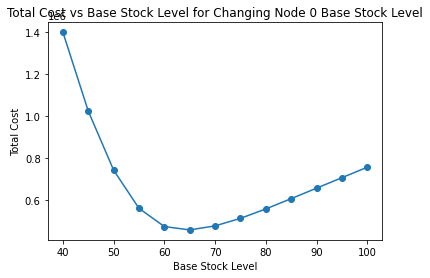

In [8]:
totalCostList = []
baseStockList = []
baseStockTestDict = {0: 60, 1: 30, 2: 30}
for i in range(40,101,5):
  totalCost = 0
  baseStockTestDict = {0: i, 1: 60, 2: 60}
  
  # Print out 45 and 50 because they be funky
  myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=df["IO"], connectionCase="and", printOut=False)

  for node in myInvSim.nodeDict.values():
    #print(sum(node.costRecord))
    totalCost += sum(node.costRecord)
  totalCostList.append(totalCost)
  baseStockList.append(i)

plt.scatter(baseStockList, totalCostList)
plt.plot(baseStockList, totalCostList)
plt.title("Total Cost vs Base Stock Level for Changing Node 0 Base Stock Level")
plt.xlabel("Base Stock Level")
plt.ylabel("Total Cost")
plt.show()


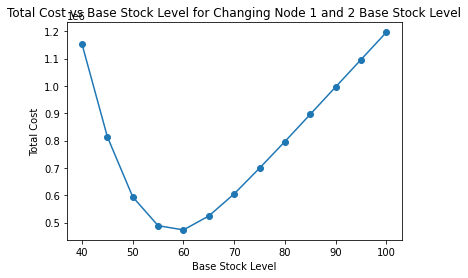

In [9]:
totalCostList = []
baseStockList = []
baseStockTestDict = {0: 60, 1: 30, 2: 30}
for i in range(40,101,5):
  totalCost = 0
  baseStockTestDict = {0: 60, 1: i, 2: i}
  
  # Print out 45 and 50 because they be funky
  myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=df["IO"], connectionCase="and", printOut=False)

  for node in myInvSim.nodeDict.values():
    #print(sum(node.costRecord))
    totalCost += sum(node.costRecord)
  totalCostList.append(totalCost)
  baseStockList.append(i)

plt.scatter(baseStockList, totalCostList)
plt.plot(baseStockList, totalCostList)
plt.title("Total Cost vs Base Stock Level for Changing Node 1 and 2 Base Stock Level")
plt.xlabel("Base Stock Level")
plt.ylabel("Total Cost")
plt.show()


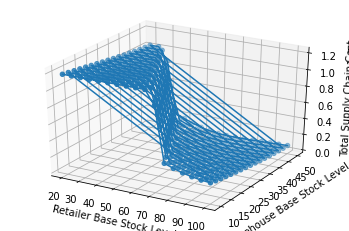

In [26]:
# FINISHED SEP 22nd, 2020

totalCostList = []
retailerBaseStockList = []
supplierBaseStockList = []
TCDict = {}
baseStockTestDict = {0: 60, 1: 30, 2: 30}

for j in range(20,101,5):
  for i in range(20,101,5):
    totalCost = 0
    baseStockTestDict = {0: i, 1: j/2, 2: j/2}
    
    myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=df["IO"], connectionCase="and", printOut=False)

    for node in myInvSim.nodeDict.values():
      totalCost += sum(node.costRecord)
    totalCostList.append(totalCost)
    retailerBaseStockList.append(i)
    supplierBaseStockList.append(j/2)
    
    TCDict[i, j/2] = totalCost

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(np.array(retailerBaseStockList), np.array(supplierBaseStockList), np.array(totalCostList))
ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

plt.show()

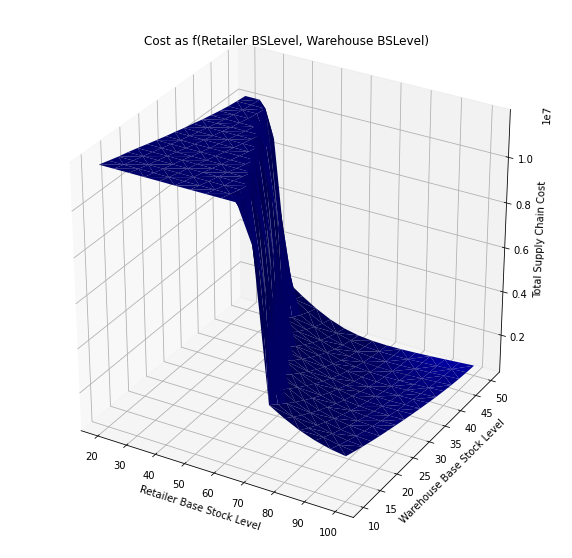

In [38]:
x = np.array(retailerBaseStockList)
y = np.array(supplierBaseStockList)
z = np.array(totalCostList)

fig = plt.figure()
ax = plt.axes(projection='3d',)
surf = ax.plot_trisurf(x, y, z, color='blue')
ax.set_title('Cost as f(Retailer BSLevel, Warehouse BSLevel)')
ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)

plt.show()

### Find the minimum value of basic 3-node simulation (Node 0 retailer, node 1 and 2 wholesaler

In [39]:
# Find the minimum of the above simulation

minTC = float('inf')
bestRetailerBS = 0
bestWholesalerBS = 0

for i in range(len(totalCostList)):
  if totalCostList[i] < minTC:
    minTC = totalCostList[i]
    bestRetailerBS = retailerBaseStockList[i]
    bestWholesalerBS = supplierBaseStockList[i]

print("Minimum Cost for this simulation")
print("Lowest Cost found: " + str(minTC))
print("Associated Retailer Base Stock Level: " + str(bestRetailerBS))
print("Associated Wholesaler Base Stock Level: " + str(bestWholesalerBS))

Minimum Cost for this simulation
Lowest Cost found: 511109.6726379993
Associated Retailer Base Stock Level: 70
Associated Wholesaler Base Stock Level: 50.0


## PRINTING METHOD DEMO

In [ ]:
# printing method demo:
for node in myInvSim.nodeDict.values():
  print(node)

## Excel Export of Last Run of Simulation



In [47]:
# Export to Excel Method Demo:

def createExcelFile(myInvSim, fname):

  nodeDataDF = {}

  for node in myInvSim.nodeDict.values():
    nodeDataDF["node " + str(node.id) + " starting Inventory"] = node.startingInventoryRecord
    nodeDataDF["node " + str(node.id) + " backorders Fulfilled"] = node.backordersFulfilledArray
    nodeDataDF["node " + str(node.id) + " demand"] = node.demandArray
    nodeDataDF["node " + str(node.id) + " supply"] = node.supplyArray
    nodeDataDF["node " + str(node.id) + " backorders"] = node.backorderRecord
    nodeDataDF["node " + str(node.id) + " ending Inventory"] = node.endingInventoryRecord
    nodeDataDF["node " + str(node.id) + " cost"] = node.costRecord

  nodeDataDF = pd.DataFrame(nodeDataDF)
  nodeDataDF.to_excel(fname)

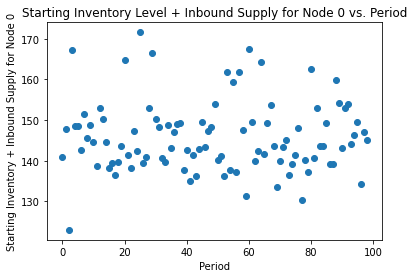

In [40]:
# Checking Starting Supply over Time (old code, no need to use and probably doesn't work anymore)

from operator import add
import matplotlib.pyplot as plt

startingInv = myInvSim.nodeDict[0].startingInventoryRecord[1:100]

node1Supply = myInvSim.nodeDict[1].supplyArray
node2Supply = myInvSim.nodeDict[2].supplyArray

combinedSupply = list(map(add, node1Supply, node2Supply))[0:99]

shouldbe60 = list(map(add, combinedSupply, startingInv))

pd = [i for i in range(len(shouldbe60))]

scat = plt.scatter(pd, shouldbe60)
plt.title("Starting Inventory Level + Inbound Supply for Node 0 vs. Period")
plt.xlabel("Period")
plt.ylabel("Starting Inventory + Inbound Supply for Node 0")
plt.show()

## PLOTS

[40.82375027, 52.14738966, 79.19040905, 61.85601662, 36.70110442, 51.53137083, 58.87915053, 42.70123029, 45.69994232, 51.16895781, 43.48706562, 61.38417397, 58.46005835, 58.13622274, 36.45920065, 61.74922034, 27.56656843, 36.50381173, 60.36212938, 66.64064414, 51.86150135, 39.65202476, 61.92064406, 64.49842163, 72.16493242, 50.5484571, 61.22740136, 70.23851942, 67.30550516, 50.70894152, 49.66626021, 51.651557200000006, 39.04665674, 60.36735494, 61.57452334, 31.56213525, 52.9975285, 45.96696994, 50.67866964, 37.05923248, 57.27456547, 27.80966755, 58.67312383, 27.50731206, 42.99213881, 50.48325582, 57.02490026, 59.77717556, 61.57310037, 42.26120875, 40.11569481, 41.14122154, 63.70395486, 51.80457876, 64.19595124, 45.09078734, 62.77196325, 49.05468807, 47.45456837, 68.58260201, 51.04805338, 51.60903641, 61.60623207, 69.15165476, 54.74981851, 63.19736871, 63.98146217, 39.82352177, 56.47427921, 27.15058848, 40.00453217, 43.26255829, 54.98899959, 31.4005582, 60.84010786, 30.67574049, 51.9129

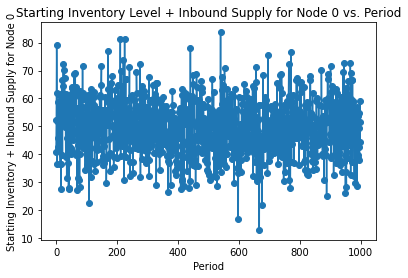

In [41]:
# Demand for Node 0 over time

pd0Demand = myInvSim.nodeDict[0].demandArray
print(pd0Demand)

estaPD = [i for i in range(len(pd0Demand))]

plt.scatter(estaPD, pd0Demand)
plt.plot(estaPD, pd0Demand)
plt.title("Starting Inventory Level + Inbound Supply for Node 0 vs. Period")
plt.xlabel("Period")
plt.ylabel("Starting Inventory + Inbound Supply for Node 0")
plt.show()

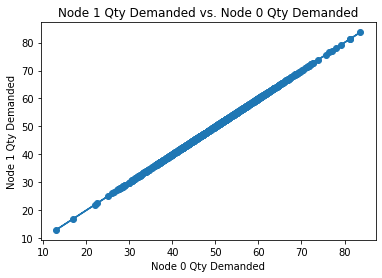

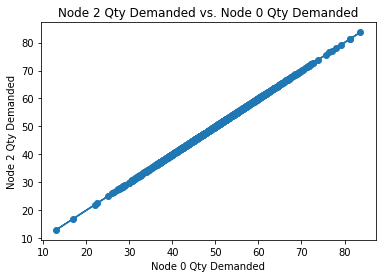

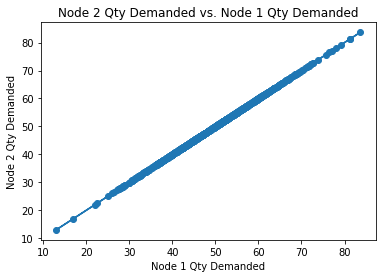

In [42]:
# Demand for Node 0 over time

node0Demand = myInvSim.nodeDict[0].demandArray
node1Demand = myInvSim.nodeDict[1].demandArray
node2Demand = myInvSim.nodeDict[2].demandArray

plt.scatter(node0Demand, node1Demand)
plt.plot(node0Demand, node1Demand)
plt.title("Node 1 Qty Demanded vs. Node 0 Qty Demanded")
plt.xlabel("Node 0 Qty Demanded")
plt.ylabel("Node 1 Qty Demanded")
plt.show()

plt.scatter(node0Demand, node2Demand)
plt.plot(node0Demand, node2Demand)
plt.title("Node 2 Qty Demanded vs. Node 0 Qty Demanded")
plt.xlabel("Node 0 Qty Demanded")
plt.ylabel("Node 2 Qty Demanded")
plt.show()

plt.scatter(node1Demand, node2Demand)
plt.plot(node1Demand, node2Demand)
plt.title("Node 2 Qty Demanded vs. Node 1 Qty Demanded")
plt.xlabel("Node 1 Qty Demanded")
plt.ylabel("Node 2 Qty Demanded")
plt.show()

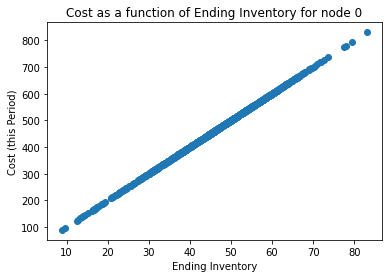

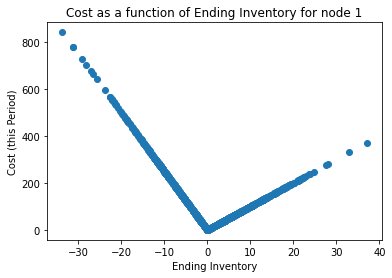

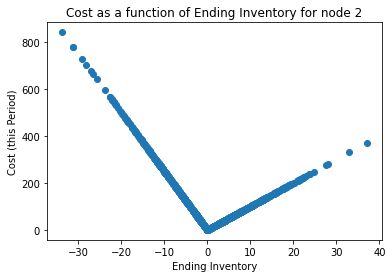

In [43]:
for node in myInvSim.nodeDict.values():
  cost = node.costRecord
  EI = node.endingInventoryRecord
  plt.scatter(EI, cost)
  plt.xlabel("Ending Inventory")
  plt.ylabel("Cost (this Period)")
  plt.title("Cost as a function of Ending Inventory for node " + str(node.id))
  plt.show()

## Node Creation using Text file (CSV) (in progress, started 27SEP2020)

In [86]:
# Create nodes using a CSV file
def createNodesUsingCSVFile(invSim, filePath, debugMessages=False):
  '''
  Create nodes using a CSV file (procedural)
  CSV file must have columns named for the following:
  - nodeID
  - h
  - p
  - demandMean
  - demandStDev

  In: InventorySimulation object, filePath (str), debugMessages (boolean, optional)

  debugMessages - option to print out messages as the file is read
  '''
  if debugMessages:
    print("Opening CSV file...")
  nodesToCreate = pd.read_csv(filePath)

  if debugMessages:
    print("Reading Data...")

  for index, row in nodesToCreate.iterrows():
    invSim.createNode(nodeID = row['nodeID'], h = row['h'], p = row['p'], demandMean=row['demandMean'], demandStDev=row['demandStDev'])
    if debugMessages:
      print("Node " + str(row['nodeID']) + " has been created")
  if debugMessages:
    print("Nodes created.  Operation Complete")


# Create an inventory simulation object to test the method on
invSim2 = InvSimulation()
createNodesUsingCSVFile(invSim2, '3nodeSimulationNodeCreation.csv', debugMessages=True)

Opening CSV file...
Reading Data...
Node 0 has been created
Node 1 has been created
Node 2 has been created
Nodes created.  Operation Complete


## Notes / Tasks / TODO

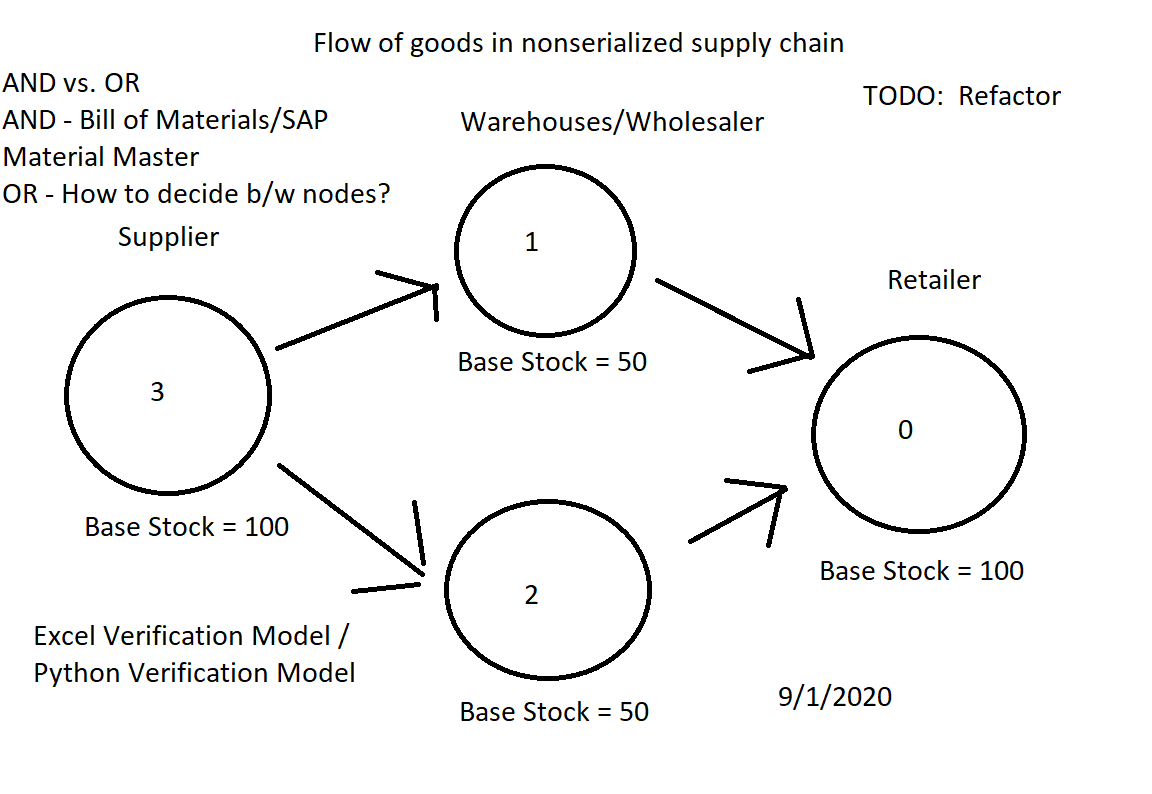

In [ ]:
'''
TODO:  15SEP2020



Things to do:
- Change base stock level for node 1 and node 2 to 50 (actually 30)
- Plot cost as a function of base stock level (see above, change up the nodes)
- AND case issue...  How to implement ordering?

'''

'''
Notes:
Total Cost as a function of base stock level
Allow user to specify base stock level for specific nodes

- Change one base stock level, keep other two constant, and plot the total SC cost
-> Rinse and repeat for the other nodes


AND siutation:
Node 1 has inventory of 100
Node 2 has inventory of 80
Can retailer see the inventory for both?

Node 0 orders what it needs, if extra stuff arrives, then it has to just let it sit there?

Implement using a dictionary w/ PreDict and RecDict values

Assume that node 1 and 2 have their inventories
If node 0 orders, node 0 doesn't have matching pairs, it needs to hang on to the extra

Right now nobody's selfish

Assembly Supply Chain:  ex: 0->1->2
There is an optimal policy

"Diamond" Supply chain (see image)

Distribution nodes screw things up, make the problems harder
-> Because of allocation
'''

Notes for 22SEP2020:

Tasks TODO:
- Implement "and" case...  Taking longer than expected
- Find the minimum of that 3-D plot that compared the base stock level of the retailer vs. the wholesaler's costs
- Implement a random demand (that can take a seed)
 - Option in code "useRandomDemand" with optional parameter "seed"